# Binary Classification Tutorial

**Author**: Adam Klie<br> 
**Last Updated**: 10/18/2022

In this tutorial, we illustrate a basic workflow in EUGENe for training a binary classsification model on some dummy data. The data comes built in with this repository and was copied over from the [Janggu package repository](https://github.com/BIMSBbioinfo/janggu). It consists of a set of "pseudo" genomic regions that we break up into 200bp bins for training and testing, with a set of peaks from a dummy BED file for defining bins in the positive class. The goal is to train a model that can predict whether a given genomic bin overlaps a peak or not.

We will also explore training a double stranded ("ds") model in this tutorial that uses information from the forward and the reverse complement strand. The model architecture we will use was built using the steps defined in the `adding_a_model_tutorial.ipynb` notebook, so check that out if you are curious!

We are assuming a little more familiarity with EUGENe than in the [`basic_usage_tutorial` in the documentation](https://eugene-tools.readthedocs.io/en/latest/basic_usage_tutorial.html).

> **Warning** 
> Before you start! Running this notebook without a GPU on this data is feasible but will be very slow. We'd recommend using [Google Colab](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) if you don't have access to your own GPU.

# Configuring

In [22]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

import os
import glob
import numpy as np
import eugene as eu

To make the sometimes painful process of keeping track of global parameters and input/output file paths easier, we usually like to set these through `eu.settings` up front. We can also do things like set the random seed for reproducibility (by default 13), the number of gpus available, the number of workers to use and more! 

In [23]:
# Configure EUGENe directories, if you do not set these, EUGENe will use the default directories. These are the ones I use!
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/tutorial_configs" # Directory to specify when you want to load a model from a config file
eu.settings.dataset_dir = "/cellar/users/aklie/projects/EUGENe/eugene/datasets/janggu_resources" # Directory where EUGENe will download datasets to
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/tutorial_output" # Directory where EUGENe will save output files to
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/tutorial_figures" # Directory to specify to EUGENe to save figures to

## Dataloading

Here we will use a [`pseudo_genome.fa`](https://github.com/BIMSBbioinfo/janggu/tree/5128419cf404d8f1904d46c627c0c7963356fff1/src/janggu/resources) copied from the Janggu package that is just a concatenation of all sequences in `sample.fa` and `sample2.fa`. The regions of interest (ROIs) are from two "pseudo-chromosomes" within this file and are contained in the [`roi_train.bed`](https://github.com/BIMSBbioinfo/janggu/blob/master/src/janggu/resources/roi_train.bed) and [`roi_test.bed`](https://github.com/BIMSBbioinfo/janggu/blob/master/src/janggu/resources/roi_test.bed) files for train and test respectively. The peaks are contained in the [`scores.bed`](https://github.com/BIMSBbioinfo/janggu/blob/master/src/janggu/resources/scores.bed) file and are used to define the positive class bins.   

In [16]:
# Let's define our file names up front with some variables
ref_file = "pseudo_genome.fa"
roi_train_file = "roi_train.bed"
roi_test_file = "roi_test.bed"
bed_file = "scores.bed"

In [17]:
# Read in the training and test regions of interest into SeqData objects
sdata_train = eu.dl.read_bed(
    bed_file=os.path.join(eu.settings.dataset_dir, bed_file),
    roi_file=os.path.join(eu.settings.dataset_dir, roi_train_file),
    ref_file=os.path.join(eu.settings.dataset_dir, ref_file),
    binsize=200, 
    add_seqs=True,
    return_janggu=False
)
sdata_test = eu.dl.read_bed(
    bed_file=os.path.join(eu.settings.dataset_dir, bed_file),
    roi_file=os.path.join(eu.settings.dataset_dir, roi_test_file),
    ref_file=os.path.join(eu.settings.dataset_dir, ref_file),
    binsize=200,
    add_seqs=True,
    return_janggu=False
)
sdata_train, sdata_test

Decoding sequences:   0%|          | 0/7797 [00:00<?, ?it/s]

Reverse complementing sequences:   0%|          | 0/7797 [00:00<?, ?it/s]

Decoding sequences:   0%|          | 0/200 [00:00<?, ?it/s]

Reverse complementing sequences:   0%|          | 0/200 [00:00<?, ?it/s]

(SeqData object with = 7797 seqs
 seqs = (7797,)
 names = (7797,)
 rev_seqs = (7797,)
 ohe_seqs = (7797, 4, 200)
 ohe_rev_seqs = None
 seqs_annot: 'target'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 200 seqs
 seqs = (200,)
 names = (200,)
 rev_seqs = (200,)
 ohe_seqs = (200, 4, 200)
 ohe_rev_seqs = None
 seqs_annot: 'target'
 pos_annot: None
 seqsm: None
 uns: None)

In [ ]:
# Check what annotations we have for this dataset
sdata_train.seqs_annot

We can see that each SeqData contains sequences from a single pseudochromsome and that the only metadata we currenly have from these sequences is the class label under the "target" column.

We can use the `add_ranges_sdata` EUGENe helper function to add the chromosome name, start and end for each sequence. This is often useful for preprocessing, downstream analysis, and visualization, but is not required for training on this particular dataset since things are already split for us.

In [25]:
eu.pp.add_ranges_sdata(sdata_train)

## Data Visualization
This is a relatively boring dataset when it comes to metadata, but we can still visualize the distribution of the positive and negative classes in the training and test sets.

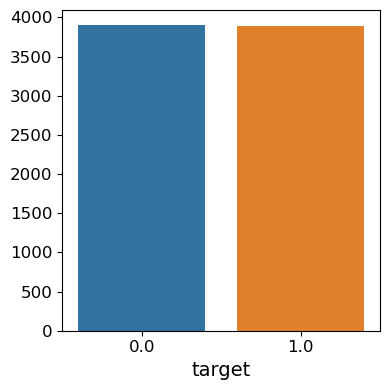

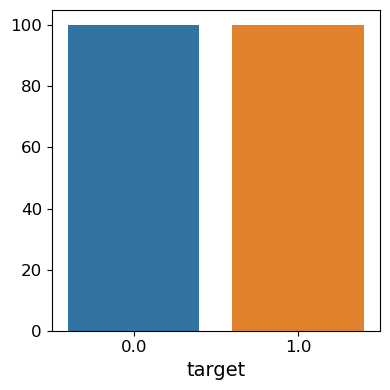

In [27]:
# Let's just quickly check the distribution of our labels.
eu.pl.countplot(
    sdata_train,
    keys=["target"],
    figsize=(4, 4),
)
eu.pl.countplot(
    sdata_test,
    keys=["target"],
    figsize=(4, 4),
)

## Preprocessing

### Sequence preprocessing
Since Janggu already loaded in the one-hot encoded sequences, we don't need to repeat this step. However, we will be training a double stranded model for this tutorial, so we need to get one-hot encoded sequences for the reverse complements too!

In [50]:
# One hot encode all the sequences in the sdata using the wrapper function
eu.pp.reverse_complement_seqs_sdata(sdata_train)
eu.pp.reverse_complement_seqs_sdata(sdata_test)

SeqData object modified:
	ohe_rev_seqs: None -> 200 ohe_rev_seqs added


### Dataset preprocessing
As is standard machine learning practice, we also need to split our data into training, validation, and test sets. This dataset came already splt into 'train' and 'test', but we also need to split the training sequences into train and validation sets. We can do this using the `train_test_split_sdata` function from the `pp` module that wraps `sklearn`.

In [29]:
# Split into train and test sets
eu.pp.train_test_split_sdata(sdata_train, split=0.8)

SeqData object modified:
    seqs_annot:
        + train_val


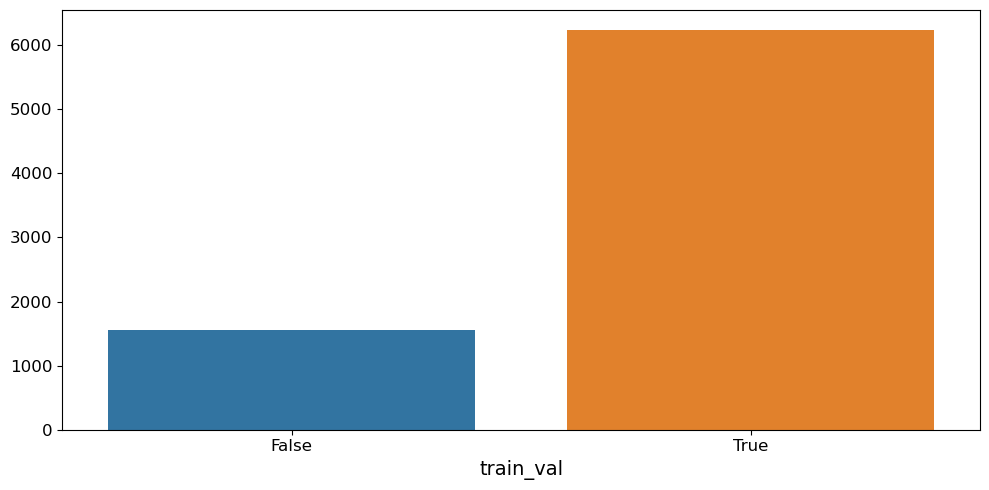

In [30]:
# Check the split with a count plot
eu.pl.countplot(
    sdata_train,
    keys="train_val",
    orient="h"
)

## Training
Now that we have our data ready, it's time to train our model. 

### Instantiation and initialization

We first need to instantiate and initialize our model. We can use the `models` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#models-instantiate-and-initialize-neural-network-architectures) to do this.

Here we will instantiate a the TutorialCNN architecture from the `adding_a_model_tutorial.ipynb` notebook that contains a single convoultional block that feeds into a single fully connected layer. We will also need to tell EUGENe we want the model to perform binary classification, and to use the binary cross entropy loss function.

In [40]:
# Load the built in tutorial model
model = eu.models.TutorialCNN(
    input_len=200,
    output_dim=1,
    strand="ds",
    task="binary_classification",
    loss_fxn="bce"
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [41]:
# Print out a summary of the model
model.summary()

Model: TutorialCNN
Input length: 200
Output dimension: 1
Strand: ds
Task: binary_classification
Aggregation: avg
Loss function: binary_cross_entropy_with_logits
Optimizer: adam
	Optimizer parameters: {}
Learning rate: 0.001
Scheduler: lr_scheduler
Scheduler patience: 2


  | Name      | Type    | Params
--------------------------------------
0 | hp_metric | AUROC   | 0     
1 | conv1     | Conv1d  | 2.6 K 
2 | dense     | Linear  | 31    
3 | sigmoid   | Sigmoid | 0     
--------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)

In [42]:
# Initialize the weights
eu.models.init_weights(model)

### Model fitting

With a model intantiated and initialized, we are set up to fit our model to some data. We can do this through the `train` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#train). 

If you are using GPU accelerators on your machine, you can can use the `gpus` argument to set the number gpus you want to use. If left empty, EUGENe will try to infer the number of GPUs available. Training the model with a single GPU will take about 35 seconds.

In [43]:
eu.train.fit(
    model=model, 
    sdata=sdata_train, 
    gpus=1, 
    target_keys="target",
    train_key="train_val",
    epochs=50,
    batch_size=128,
    num_workers=0,
    seed=13,
    version="tutorial_model"
)

Global seed set to 13
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.
No transforms given, assuming just need to tensorize.


Set SLURM handle signals.

  | Name      | Type    | Params
--------------------------------------
0 | hp_metric | AUROC   | 0     
1 | conv1     | Conv1d  | 2.6 K 
2 | dense     | Linear  | 31    
3 | sigmoid   | Sigmoid | 0     
--------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
Global seed set to 13
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottle

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

We can see how well our models trained by plotting a training summary. All you need to do is point the [`training_summary`](https://eugene-tools.readthedocs.io/en/latest/api/eugene.pl.training_summary.html#eugene.pl.training_summary) function to your the EUGENe logging directory.

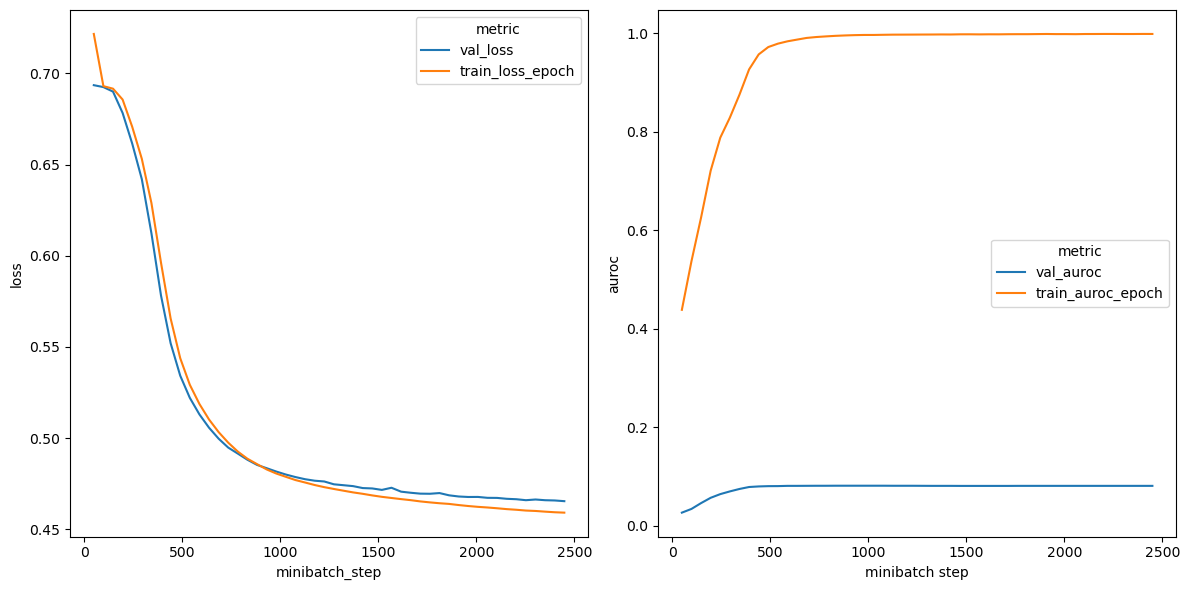

In [44]:
# Plot a loss curve and an r2 curve as a metric
eu.pl.training_summary(
    os.path.join(eu.settings.logging_dir, "dsTutorialCNN_binary_classification", "tutorial_model"),
    metric="auroc"
)

## Evaluation
After the model's been trained, we can evaluate our performance on our held-out test data. This is done through the `evaluate` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#evaluate).

It is often best to use the model that achieved the lowest loss on the validation data for evaluation. We can load this model in from the log directory:

In [46]:
# We point to the checkpoints directory within the logging directory to grab the best model
model_file = glob.glob(os.path.join(eu.settings.logging_dir, "dsTutorialCNN_binary_classification", "tutorial_model", "checkpoints", "*"))[0]
best_model = eu.models.TutorialCNN.load_from_checkpoint(model_file)

In [51]:
# This should look familiar!
best_model.summary()

Model: TutorialCNN
Input length: 200
Output dimension: 1
Strand: ds
Task: binary_classification
Aggregation: avg
Loss function: binary_cross_entropy_with_logits
Optimizer: adam
	Optimizer parameters: {}
Learning rate: 0.001
Scheduler: lr_scheduler
Scheduler patience: 2


  | Name      | Type    | Params
--------------------------------------
0 | hp_metric | AUROC   | 0     
1 | conv1     | Conv1d  | 2.6 K 
2 | dense     | Linear  | 31    
3 | sigmoid   | Sigmoid | 0     
--------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)

And then use it to make predictions on our held out test data.

In [52]:
# Use this best model to predict on the held-out data. This will store predictions in
# the SeqData object and also write them to disk by default in eugene.settings.output_dir
eu.evaluate.predictions(
    best_model,
    sdata=sdata_test,
    target_keys="target",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize.


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + tutorial_model_target_predictions


We know have predictions from our trained model! Let's look at a metric to see how we did. Since our labels are completely balanced in our test set, we can use the area under the reciever operator characterstic (auROC) to evaluate our model.

<AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>

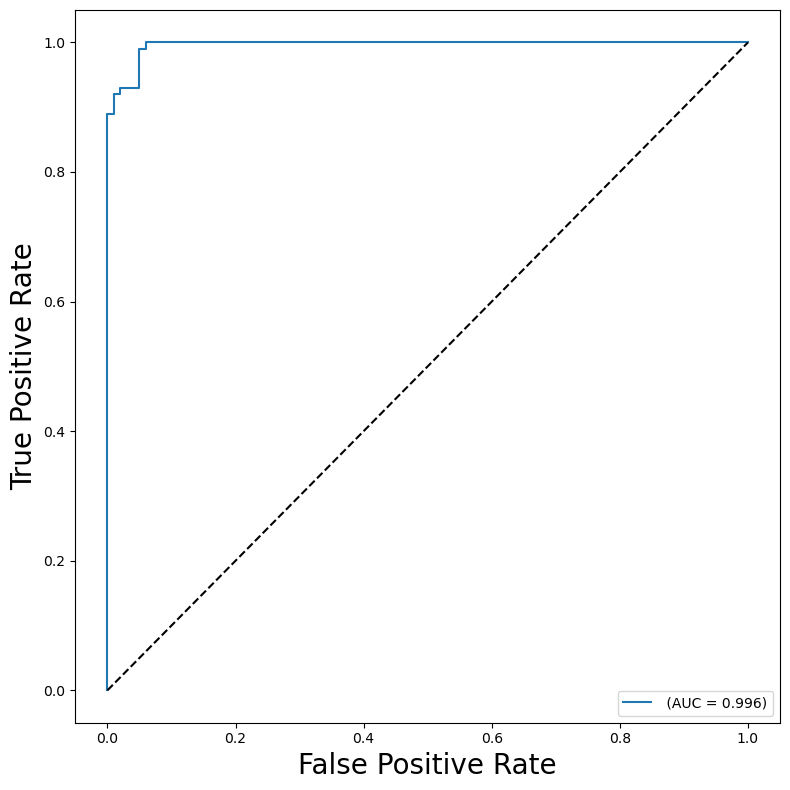

In [54]:
eu.pl.auroc(
    sdata_test, 
    target_keys="target", 
    prediction_keys="tutorial_model_target_predictions",
    figsize=(8, 8)
)

## Interpretation

We are also usually interested in understanding how our model is working to make the predictions it does. This is done through the `interpret` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#interpret). 

There are many options for interpreting the model's predictions, and we will again point users to the [API](https://eugene-tools.readthedocs.io/en/latest/api.html#interpret) for all the options and their arguments. We run through examples for a few common ones below.

### Feature attribution
We can calculate the contribution of each nucleotide to the model's predictions for a sequence by using the `interpret` module's `feature_attribution_sdata` function. We currently implement several different methods for this, includeing `DeepLIFT`, `ISM`, `InputXGradient` and `GradientSHAP`.

Here we will aply the `InputXGradient` method to our best model on our held-out test sequences.

In [56]:
eu.interpret.feature_attribution_sdata(
    model=best_model,
    sdata=sdata_test,
    method="InputXGradient"
)

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/1 [00:00<?, ?it/s]

We can then visualize these importance scores using a sequence logo plot. Here we show the results on the forward and reverse strands for for the three highest predicted sequences by our model.

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

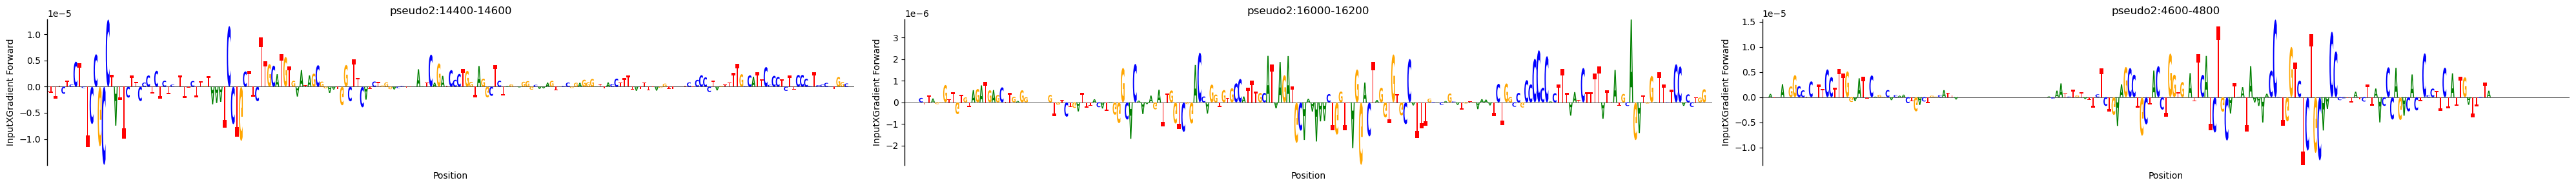

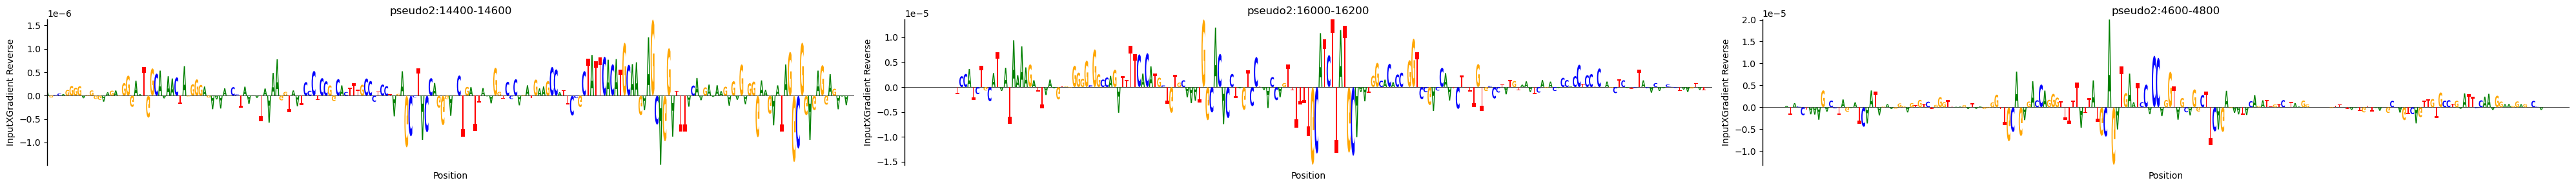

In [62]:
# Grab the top3 in terms of predictions to plot tracks for
top3 = sdata_test["tutorial_model_target_predictions"].sort_values(ascending=False).iloc[:3].index

eu.pl.multiseq_track(
    sdata_test,
    seq_ids=top3,
    uns_keys = "InputXGradient_forward_imps",
    ylabs="InputXGradient Forward",
    height=3,
    width=40,
)
eu.pl.multiseq_track(
    sdata_test,
    seq_ids=top3,
    uns_keys = "InputXGradient_reverse_imps",
    ylabs="InputXGradient Reverse",
    height=3,
    width=40,
)

### Filter Visualization 
We can get an idea for what each filter of first convoulional layer of the model is seeing by using the `interpret` module's [`generate_pfms_sdata`](https://eugene-tools.readthedocs.io/en/latest/api/eugene.interpret.generate_pfms_sdata.html?highlight=generate_pfms#eugene.interpret.generate_pfms_sdata) function. This creates a position frequency matrix for each filter in the model using sequences that highly activate that filter (can be defined in multiple ways). We often times pass the the test sequences through the model, but you can theoretically pass any sequences you want.

In [ ]:
# Generate pfms from filters using method described in Minnoye et al. 2020
eu.interpret.generate_pfms_sdata(
    model=best_model, 
    sdata=sdata_test,
    method="Minnoye20"
)

No transforms given, assuming just need to tensorize.


Getting maximial activating seqlets:   0%|          | 0/55 [00:00<?, ?it/s]

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/256 [00:00<?, ?it/s]

Now let's visualize these PFMs to see if we can decipher what the filters are picking up on

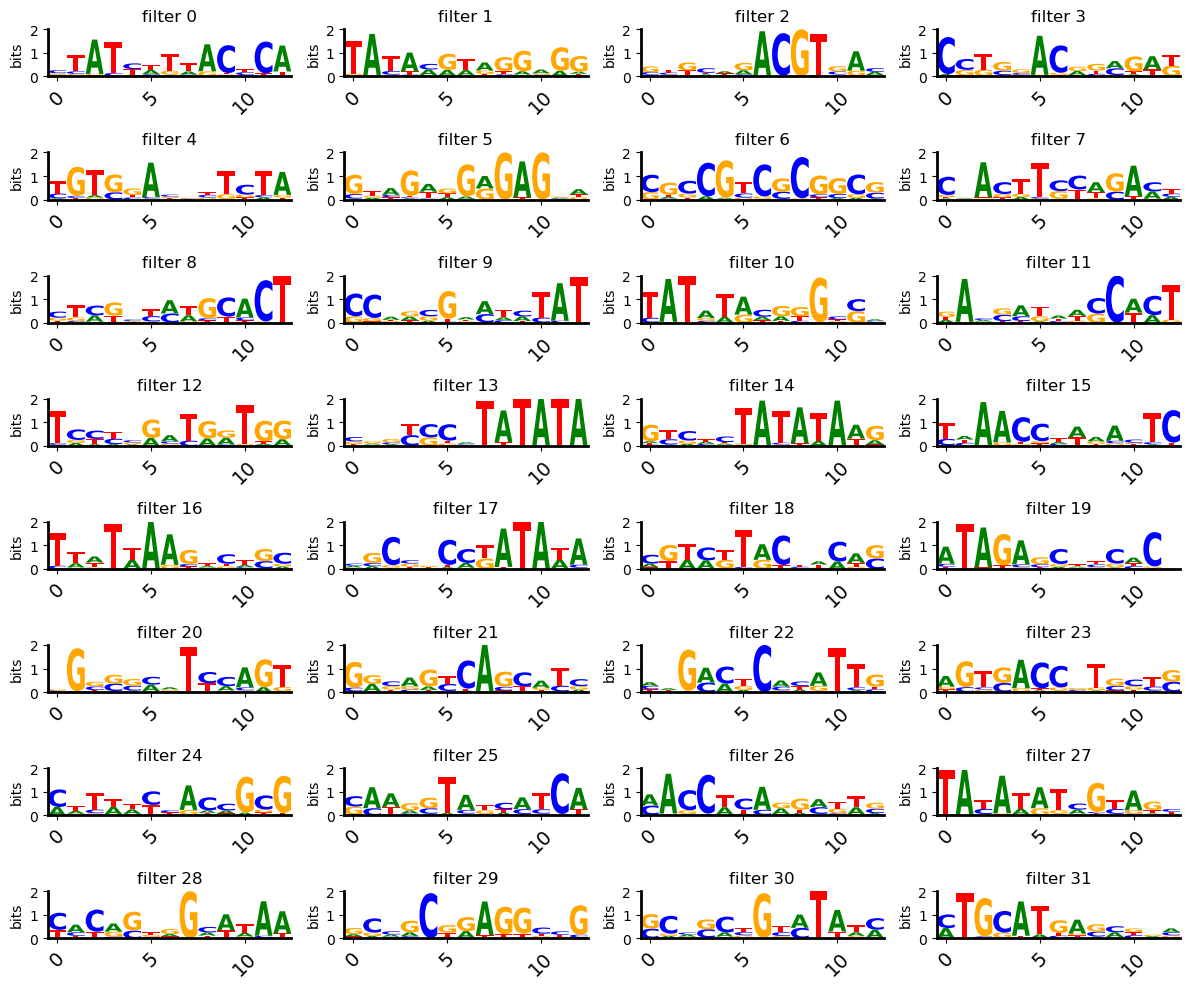

In [ ]:
# We can visualize these PFMs as PWM logos
eu.pl.lm_multifilter_viz(
    sdata_test,
    filter_ids=list(sdata_test.uns["pfms"].keys())[:32],
    num_rows=8,
    num_cols=4,
    titles=[f"filter {i}" for i in range(0, 32)],
)

The qualitative visualization is nice, but often times we want to put some numbers behind what we are seeing. This is often done by annotating them PFMs from these filters against a database of known motifs with tools like [TomTom](https://meme-suite.org/meme/tools/tomtom). We offer a function for saving filters in an SeqData object to the MEME file format that can uploaded to the TomTom webtool.

In [ ]:
eu.dl.motif.filters_to_meme_sdata(
    sdata_test,
    filter_ids=list(sdata_test.uns["pfms"].keys()),
    output_dir=os.path.join(eu.settings.output_dir),
    file_name="tutorial_model_filters.meme"
)

Saved PWM File as : /cellar/users/aklie/tutorial_output/tutorial_model_filters.meme


## Wrapping up
Like most of EUGENe, this tutorial is very much a work in progress. Don't hesitate to raise a GitHub issue if you run into any errors or if anything is overly confusing!

We will also be adding new tutorials on [the GitHub very soon!](https://github.com/cartercompbio/EUGENe/tree/main/tutorials)

---